In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D
from sklearn.metrics import accuracy_score

In [2]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Select binary data
label_sub = [0,1]
x_train_sub = np.array([x for x, y in zip(x_train, y_train) if y in label_sub])
y_train_sub = np.array([y for y in y_train if y in label_sub])
x_test_sub = np.array([x for x, y in zip(x_test, y_test) if y in label_sub])
y_test_sub = np.array([y for y in y_test if y in label_sub])

print('There are', len(x_train_sub), 'training images.')
print('There are', len(x_test_sub), 'test images.')

There are 12665 training images.
There are 2115 test images.


In [3]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train_sub = x_train_sub.reshape(x_train_sub.shape[0], 28, 28, 1)
x_test_sub = x_test_sub.reshape(x_test_sub.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Making sure that the values are float so that we can get decimal points after division
x_train_sub = x_train_sub.astype('float32')
x_test_sub = x_test_sub.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
x_train_sub /= 255
x_test_sub /= 255
print('x_train_sub shape:', x_train_sub.shape)
print('Number of images in x_train_sub', x_train_sub.shape[0])
print('Number of images in x_test_sub', x_test_sub.shape[0])

x_train_sub shape: (12665, 28, 28, 1)
Number of images in x_train_sub 12665
Number of images in x_test_sub 2115


In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_sub, y_train_sub)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_sub, y_test_sub)).batch(32)

In [5]:
def convert2_zero_one(x):

    t = [tf.math.sigmoid(i) for i in x]
    
    return t

def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tf.math.greater(tf.math.abs(x), r), tf.float32)
    sign = tf.math.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [6]:
# MLP model
class StochasticCNN(Model):
    
    def __init__(self, n_outputs=10):
        # preferred architecture: 784 - [32C5-P2] - [64C5-P2] - 128 - 10 with 40% dropout. 
        
        super(StochasticCNN, self).__init__()
        # define here
        self.conv1 = Conv2D(filters = 32, kernel_size = (5, 5), input_shape = input_shape, activation = 'sigmoid')
        self.conv2 = Conv2D(filters = 64, kernel_size = (5, 5), activation = 'sigmoid')
        self.max1 = MaxPooling2D(pool_size=(2, 2))
        self.max2 = MaxPooling2D(pool_size=(2, 2))
        self.dropout = Dropout((0.4))
        self.flatten = Flatten()
        self.fc1 = Dense(128) 
        self.output_layer = Dense(n_outputs)
        
    def call(self, x):
        
        network = []
        
        #--- first conv + max layer ---
        net = self.conv1(x)
        net = tfp.distributions.Bernoulli(logits=net).sample()
        
        net0_flat = tf.reshape(net, [np.shape(net)[0], -1])
        self.net0_flat_shape = np.shape(net0_flat)
        
        network.append(net)  
        net = tf.cast(net, dtype=tf.float32)
        net = self.max1(net)

        
        #--- second conv + max layer ---
        net = self.conv2(net)
        net = tfp.distributions.Bernoulli(logits=net).sample()
        
        net1_flat = tf.reshape(net, [np.shape(net)[0], -1])
        self.net1_flat_shape = np.shape(net1_flat)
        
        network.append(net)  
        net = tf.cast(net, dtype=tf.float32)
        net = self.max2(net)
        
        #--- dropout and flatten layer ---
        net = self.dropout(net)
        net = self.flatten(net)
        
        #--- dense layer ---
        net = self.fc1(net)
        net = tfp.distributions.Bernoulli(logits=net).sample()
        self.net2_flat_shape = np.shape(net)
        
        network.append(net)
        
        #--- output layer ---
        net = self.output_layer(net)
       
        # define the shape of network
        
        self.net0_shape = np.shape(network[0])[1:]
        self.net1_shape = np.shape(network[1])[1:]
        self.net2_shape = np.shape(network[2])[1:]
     
        return network
    
    
    def target_log_prob(self, x, h, y):
        
        y = [[i] for i in y]
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0. # negative log probability
        
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, [self.conv1, self.conv2, self.fc1])):
            
            if i == 0:
                ce = tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=cv, logits=layer(pv))
            
                nlog_prob += tf.reduce_sum(ce, axis = (1,2,3))
                
            if i == 1:
                
                max1 = self.max1(pv)
                ce = tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=cv, logits=layer(max1))
            
                nlog_prob += tf.reduce_sum(ce, axis = (1,2,3))
        
            if i == 2:
                
                max2 = self.max2(pv)
                dropout = self.dropout(max2)
                flat = self.flatten(dropout)
                
                ce = tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=cv, logits=layer(flat))
            
                nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        
        nlog_prob += tf.reduce_sum(fce, axis = -1)   
            
        return -1 * nlog_prob
    
    def target_log_prob2(self, x, h, y):
        
        #x = Flatten()(x)
        y = [[i] for i in y]
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        
        # self.net1_flat_shape = [32,24*24*32]
        # self.net2_flat_shape = [32,8*8*64]
        # self.net1_flat_shape = [32,128]
        
        
        split0, split1, split2 = tf.split(h_current, [self.net0_flat_shape[1], \
                                                      self.net1_flat_shape[1], self.net2_flat_shape[1]], 1)
        batch_size = np.shape(split0)[0]
        
        
        s0_l = self.net0_shape.as_list()
        s0_l.insert(0, batch_size)
        
        s1_l = self.net1_shape.as_list()
        s1_l.insert(0, batch_size)
        
        s2_l = self.net2_shape.as_list()
        s2_l.insert(0, batch_size)

        
        split0 = tf.reshape(split0, s0_l)
        split1 = tf.reshape(split1, s1_l)
        split2 = tf.reshape(split2, s2_l)
        
        h_current = [split0, split1, split2] 
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, [self.conv1, self.conv2, self.fc1])):
            
            if i == 0:
                ce = tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=cv, logits=layer(pv))
            
                nlog_prob += tf.reduce_sum(ce, axis = (1,2,3))
                
            if i == 1:
                
                max1 = self.max1(pv)
                ce = tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=cv, logits=layer(max1))
            
                nlog_prob += tf.reduce_sum(ce, axis = (1,2,3))
        
            if i == 2:
                
                max2 = self.max2(pv)
                dropout = self.dropout(max2)
                flat = self.flatten(dropout)
                
                ce = tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=cv, logits=layer(flat))
            
                nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        
        nlog_prob += tf.reduce_sum(fce, axis = -1)   
            
        return -1 * nlog_prob

    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_ker, update_ker = False):
        
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        orig_shape = np.shape(h_current)
        h_current = tf.reshape(h_current, [orig_shape[1], -1]) # reshape to one dimension
   
        # initialize the HMC transition kernel
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = pow(1000, -1/4)),
            num_adaptation_steps=int(100*0.8))

        # run the chain (with burn-in)
        num_results = 1
        num_burnin_steps = 100

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps, 
            current_state = h_current, # may need to be reshaped
            kernel = adaptive_hmc,
            trace_fn = None)
        
        h_new = tf.reshape(samples[0], orig_shape)

        return(h_new)
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

     
        logits = self.conv1(x)
        x = tf.math.sigmoid(logits)
        
        logits = self.max1(x)
        x = tf.math.sigmoid(logits)
            
        logits = self.conv2(x)
        x = tf.math.sigmoid(logits)
            
        logits = self.max2(x)
        x = tf.math.sigmoid(logits)
        
        logits = self.dropout(x)
        x = tf.math.sigmoid(logits)
        
        logits = self.flatten(x)
        x = tf.math.sigmoid(logits)
        
        logits = self.fc1(x)
        x = tf.math.sigmoid(logits)
            
        logits = self.output_layer(x)
        probs = tf.math.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tf.math.greater(probs, 0.5), tf.int32)

        return labels

In [7]:
model = StochasticCNN(n_outputs = 1)

In [8]:
network = [model.call(images) for images, labels in train_ds]

In [9]:
tlp = [model.target_log_prob(images, network[bs], labels) for bs, (images, labels) in enumerate(train_ds)]

In [10]:
kernels = [model.generate_hmc_kernel(images, labels) for images, labels in train_ds]

/Users/hmy/anaconda3/envs/deeplearning/lib/python3.6/site-packages/tensorflow_probability/python/__init__.py:74: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  'TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The '


In [11]:
burnin = 20
step_sizes = []
for i in range(burnin):
    
    print(i)
    network_new = []
    kernels_new = []
    start_time = time.time()
    
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network, kernels):
        net_current = net      
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        
        # flatten the 3-layer network
        for i in range(3):
            orig_shape = np.shape(net_current[i])
            net_current[i] = tf.reshape(net_current[i], [orig_shape[0], -1])
            
        net_current = tf.concat(net_current, axis = 1)
                
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2].new_step_size.numpy()
        step_sizes.append(new_step_size)
    
        new_state = rerange(samples[0][0])
        
        # reshape new network
        split0, split1, split2 = tf.split(new_state, [18432, 4096, 128], 1)
        batch_size = np.shape(new_state)[0]
        split0 = tf.reshape(split0, [batch_size, 24, 24, 32])
        split1 = tf.reshape(split1, [batch_size, 8, 8, 64])
        split2 = tf.reshape(split2, [batch_size, 128])
        
        net_new = [split0, split1, split2] 
        network_new.append(net_new)
        
        # build new kernel
        ker_new = model.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new.append(ker_new)
            
    network = network_new
    kernels = kernels_new
    
    print("Step %d - time %.4f" % (i, time.time()-start_time))

0
Step 2 - time 157.3531
1
Step 2 - time 154.8043
2
Step 2 - time 151.8502
3
Step 2 - time 153.1443
4
Step 2 - time 154.6346
5
Step 2 - time 394.6344
6
Step 2 - time 155.5563
7
Step 2 - time 153.8152
8
Step 2 - time 153.8025
9
Step 2 - time 157.5750
10
Step 2 - time 740.5149
11
Step 2 - time 153.9175
12
Step 2 - time 153.5590
13
Step 2 - time 153.7977
14
Step 2 - time 1643.7689
15
Step 2 - time 155.2559
16
Step 2 - time 151.2132
17
Step 2 - time 153.5892
18
Step 2 - time 152.5355
19
Step 2 - time 5340.0578


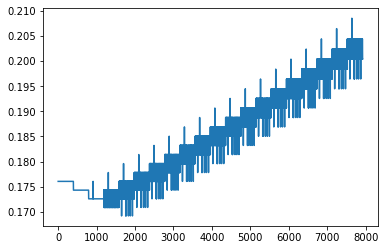

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes)), step_sizes)
plt.show()

In [ ]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (images, labels) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(images, network[bs], labels, 0.1)
        #network_new = [model.propose_new_state_hamiltonian(images, net, labels) for (images, labels), net in 
        #              zip(train_ds, network)]
        
        network_new = []
        #kernels_new = []
        for net, hmc_kernel in zip(network, kernels):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            
            # flatten the 3-layer network
            for i in range(3):
                orig_shape = np.shape(net_current[i])
                net_current[i] = tf.reshape(net_current[i], [orig_shape[0], -1])
            
            net_current = tf.concat(net_current, axis = 1)
            
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)

            #new_step_size = samples[2].new_step_size.numpy()
            
            new_state = rerange(samples[0][0])
            # reshape new network
            split0, split1, split2 = tf.split(new_state, [18432, 4096, 128], 1)
            batch_size = np.shape(new_state)[0]
            split0 = tf.reshape(split0, [batch_size, 24, 24, 32])
            split1 = tf.reshape(split1, [batch_size, 8, 8, 64])
            split2 = tf.reshape(split2, [batch_size, 128])
        
            net_new = [split0, split1, split2] 
            network_new.append(net_new)
            
            #ker_new = model.generate_hmc_kernel(images2, labels2, new_step_size)
            #kernels_new.append(ker_new)
            
        network = network_new
        #kernels = kernels_new

        loss += -1 * tf.reduce_mean(model.target_log_prob(images, network[bs], labels))
       
    preds = [model.get_predictions(images) for images, labels in train_ds]
    #print(preds)
    train_acc = accuracy_score(np.array(preds[0]), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))